
# Poleval Automatic Cyberbullying

In this task, the participants shall distinguish between three classes of tweets: 0 (non-harmful), 1 (cyberbullying), 2 (hate-speech). There are various definitions of both cyberbullying and hate-speech, some of them even putting those two phenomena in the same group. The specific conditions on which we based our annotations for both cyberbullying and hate-speech, which have been worked out during ten years of research [1] will be summarized in an introductory paper for the task, however, the main and definitive condition to distinguish the two is whether the harmful action is addressed towards a private person(s) (cyberbullying), or a public person/entity/large group (hate-speech).

## This notebook contains:

- [x] Download train, test data;
- [x] Clean the data;
- [x] Exploratory analisys;
- [x] Modeling;
- [x] Model Validation;
- [x] Save best model;
  
  
  
**AUTHOR:** Rafal Bodziony  
**EMAIL:** bodziony.rafal@gmail.com  
**LAST UPDATE:** 17.09.2020


**More information:** http://2019.poleval.pl/


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/g0lemXIV/harmfulness_app/blob/master/notebooks/Experiment_0_20200910.ipynb)

### Download and load libraries

In [ ]:
!pip install spacy==2.3.2
!python -m spacy download pl_core_news_sm
!pip install langdetect
!pip install -U yellowbrick
!pip install eli5
!pip install -U scikit-learn==0.23.2

In [2]:
import spacy
import pandas as pd
from IPython.display import clear_output
from langdetect import detect
import warnings
warnings.filterwarnings('ignore')

## Clean data

**To Do:**
- Replace additional \n;
- Delate all digits in string;
- Delate twitter account name;
- Get only words which is not puntations, stop words (from corpus),
length is grater then 3, not a number, currnecy, and email;
- Converts all words to lowercases;
- Lemmatize all words;

In [3]:
text = pd.read_csv('https://storage.googleapis.com/poleval_data/training_set_clean_only_text.txt', sep="\n", header=None, names=['text'], encoding='utf-8')
tag = pd.read_csv('https://storage.googleapis.com/poleval_data/training_set_clean_only_tags.txt', sep="\n", header=None, names=['tag'], encoding='utf-8')
print(text.shape)

def clean_data(data):
  data = data.replace(r'\\n',' ', regex=True)
  data = data.replace(r'\n',' ', regex=True)
  data['text'] = data['text'].str.replace('\d+', '')
  data.text.replace('@anonymized_account', '', regex=True, inplace=True)
  data.text.replace('#NAME?', '', regex=True, inplace=True)
  return data

(10041, 1)


In [4]:
from spacy.lang.pl.stop_words import STOP_WORDS
# Parser for reviews
print("load corpus")
try:
  parser
except NameError:
  parser = spacy.load('pl_core_news_sm')
print('corpus loaded succesfully')
def spacy_tokenizer(mytokens):
    mytokens = [word for word in mytokens if
                word.is_punct == False and word.is_stop == False
                and len(word) > 3 
                and word.like_num == False 
                and word.is_currency == False 
                and word.like_email == False]
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

load corpus
corpus loaded succesfully


In [5]:
data = pd.concat([text, tag], axis=1)
data = clean_data(data)

In [6]:
from tqdm.auto import tqdm
tokens = list()
for doc in tqdm(parser.pipe(data['text'].astype('unicode').values, batch_size=100,
                        n_threads=10)):
  tokens.append(spacy_tokenizer(doc))

# because it couse problem drop index 4081
data["processed_text"] = tokens
data = data.drop(data.index[[4081]])
data = data[~(data.processed_text.str.len() < 10)]
tqdm.pandas()
data = data[data.processed_text.progress_apply(lambda x: detect(x) == 'pl')]

In [7]:
data.sample(100).to_json('./test_case_parse_text.json')

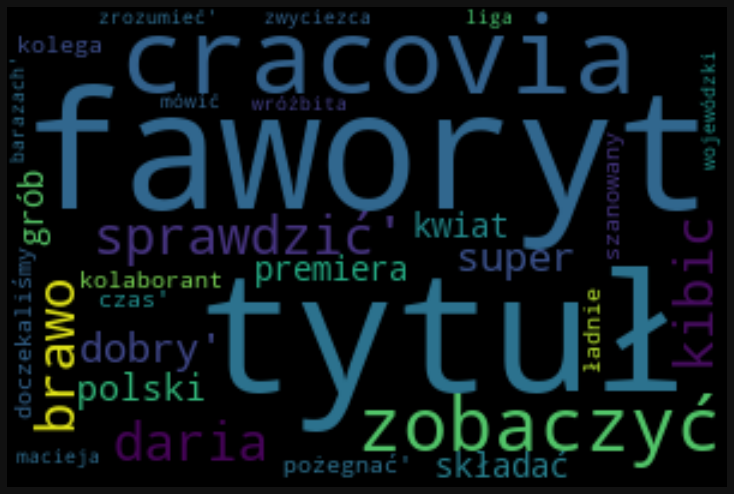

In [8]:
#@title Word Cloud grouped by type of harmfulness { run: "auto", vertical-output: true, display-mode: "form" }
tweets = "non-harmful" #@param ["non-harmful", "cyberbullying", "hate-speech"]
plot_type = "Word Cloud" #@param ["Word Cloud", "Frequency Visualizer", "Class Balance"]
tweet_dict = dict(zip(["non-harmful", "cyberbullying", "hate-speech"], [0,1,2]))

import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.target import ClassBalance
from spacy.lang.pl import STOP_WORDS
from yellowbrick import text

def plot_data(data: np.array, plot_type: str) -> None:
  if plot_type == 'Word Cloud':
    wordcloud = WordCloud(
        width = 300,
        height = 200,
        background_color = 'black').generate(str(data))
    fig = plt.figure(
        figsize = (10, 15),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
  elif plot_type == 'Frequency Visualizer':
    vectorizer = CountVectorizer(stop_words=STOP_WORDS)
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names()
    plt.rcParams['figure.figsize'] = 15, 10
    visualizer = text.FreqDistVisualizer(features=features, orient='h', n=25)
    visualizer.fit(docs)
    visualizer.poof()
  elif plot_type == 'Class Balance':
    visualizer = ClassBalance(labels=["non-harmful", "cyberbullying", "hate-speech"])
    visualizer.fit(data.tag)
    visualizer.show()

if plot_type == 'Class Balance':
  doc = data
else:
  doc = data[data.tag == tweet_dict[tweets]].processed_text.values

plot_data(doc, plot_type)
  

## Modeling part

The first model must be simple and effective as possible. First, let's try the logistic regression model. If it brings the expected results, we will be able to try other models. We compare LR to the Dummy Classifier to get the view of our progress.
The entire model will be closed in a sklearn pipeline, which will allow us to easily test various combinations of models. Next, we will cross-validate to check the model against the given F1 micro and F1 macro metrics.

**To Do:**
- Convert a collection of text documents to a matrix of token counts;
- Transform a count matrix to a normalized tf or tf-idf representation;
- Select features according to a percentile of the highest scores (with different measures);
- Add Logistic Regression model;
- Score with Cross Validation;

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('selector', SelectPercentile(chi2, percentile=50)),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=100, solver='liblinear', dual=True, random_state=23)),
               ])


X_train = data['processed_text'].values # the features we want to analyze
y_train = data['tag'].values # the labels, or answers, we want to test against

print(X_train.shape, y_train.shape)
# model generation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred), 
            metrics.f1_score(y, yPred, average='micro'), 
            metrics.f1_score(y, yPred, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)
    print("Accuracy: {} | F1 micro: {} | F1 macro: {}".format(a, p, r))
    return a+p+r
  
scores = cross_val_score(pipe, X_train, y_train, scoring=my_scorer, cv=10)

(9223,) (9223,)
Accuracy: 0.894907908992416 | F1 micro: 0.894907908992416 | F1 macro: 0.4266149870801034
Accuracy: 0.8970747562296858 | F1 micro: 0.8970747562296858 | F1 macro: 0.4463077018975748
Accuracy: 0.8884073672806068 | F1 micro: 0.8884073672806068 | F1 macro: 0.44518975716158815
Accuracy: 0.8937093275488069 | F1 micro: 0.8937093275488069 | F1 macro: 0.39997522606218255
Accuracy: 0.9045553145336226 | F1 micro: 0.9045553145336226 | F1 macro: 0.440155819055422
Accuracy: 0.8926247288503254 | F1 micro: 0.8926247288503254 | F1 macro: 0.4641400634485057
Accuracy: 0.8947939262472885 | F1 micro: 0.8947939262472885 | F1 macro: 0.4135228251507322
Accuracy: 0.886117136659436 | F1 micro: 0.886117136659436 | F1 macro: 0.3893495956715698
Accuracy: 0.8980477223427332 | F1 micro: 0.8980477223427332 | F1 macro: 0.39170968081744445
Accuracy: 0.9013015184381779 | F1 micro: 0.9013015184381779 | F1 macro: 0.46243675684868407


In [10]:
# Fit pipe with a train dataset
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function chi2 at 0x7f849d2526a8>)),
                ('clf',
                 LogisticRegression(C=100000.0, dual=True, n_jobs=1,
                                    random_state=23, solver='liblinear'))])

## Test Model

In [11]:
# test 
text_test = pd.read_csv('https://storage.googleapis.com/poleval_data/test_set_only_text.txt', sep="\n", header=None, names=['text'], encoding='utf-8')
tag_test = pd.read_csv('https://storage.googleapis.com/poleval_data/test_set_only_tags.txt', sep="\n", header=None, names=['tag'], encoding='utf-8')

data_test = pd.concat([text_test, tag_test], axis=1)

d_comp = data_test.copy()
# d_comp = d_comp.text.str.replace('@anonymized_account', '')
d_comp = clean_data(d_comp)
# data = data[data.text.apply(lambda x: detect(x) == 'pl')]

d_comp.shape, data_test.shape

((1000, 2), (1000, 2))

In [12]:
d_comp.head()

,text,tag
0,"Spoko, jak im Duda z Morawieckim zamówią po p...",0
1,"Ale on tu nie miał szans jej zagrania, a ta ...",0
2,"No czy Prezes nie miał racji, mówiąc,ze to są...",0
3,Przecież to nawet nie jest przewrotka 😂,0
4,Owszem podatki tak. Ale nie w takich okolicz...,0


In [13]:
tokens = list()
for doc in tqdm(parser.pipe(d_comp['text'].astype('unicode').values, batch_size=100,
                        n_threads=5)):
  tokens.append(spacy_tokenizer(doc))

d_comp["processed_text"] = tokens

d_comp.shape

(1000, 3)

In [14]:
# predicted = pipe.predict(d_comp["processed_text"].values)
predicted = np.argmax(pipe.predict_proba(d_comp["processed_text"].values), axis=1)
y_test_dev = d_comp['tag']

In [15]:
# dummy predictor
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
predicted_dumy = dummy_clf.predict(d_comp["processed_text"].values)
print("Dummy classifier Accuracy:",metrics.accuracy_score(y_test_dev, predicted_dumy))
print("Dummy classifier F1 micro:",metrics.f1_score(y_test_dev, predicted_dumy, average='micro'))
print("Dummy classifier F1 macro:",metrics.f1_score(y_test_dev, predicted_dumy, average='macro'))

Dummy classifier Accuracy: 0.866
Dummy classifier F1 micro: 0.866
Dummy classifier F1 macro: 0.3093962129331904


In [16]:
# Model Accuracy
print(predicted.shape)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test_dev, predicted))
print("Logistic Regression F1 micro:",metrics.f1_score(y_test_dev, predicted, average='micro'))
print("Logistic Regression F1 macro:",metrics.f1_score(y_test_dev, predicted, average='macro'))

(1000,)
Logistic Regression Accuracy: 0.878
Logistic Regression F1 micro: 0.878
Logistic Regression F1 macro: 0.48279464839651826


## Explain and save

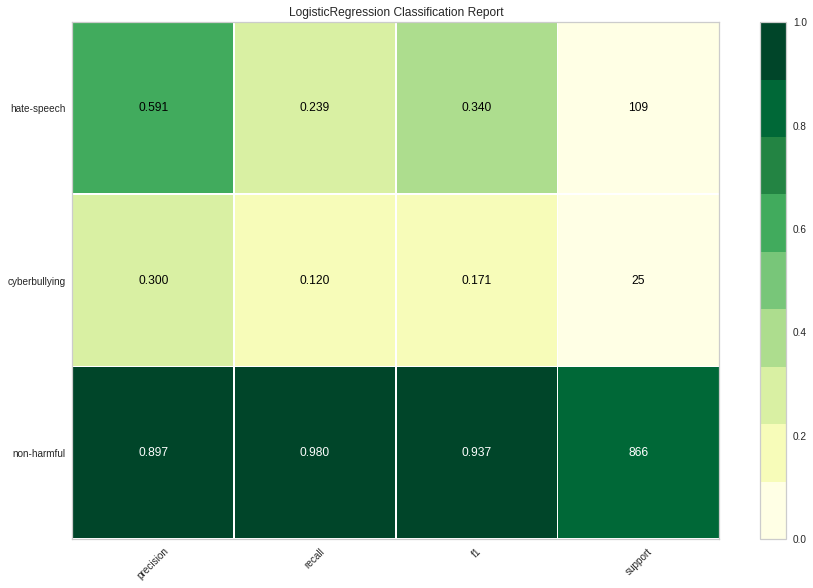

In [17]:
#@title Model Explain { run: "auto", vertical-output: true }
plot_type = "Classification Report" #@param ["Classification Report", "Confusion Matrix", "ROCAUC", "Class Prediction Error"]

import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError

classes = ["non-harmful", "cyberbullying", "hate-speech"]

def visualize_model(X, y, estimator, plot_type):

    if plot_type == 'Classification Report':
      visualizer = ClassificationReport(estimator, support=True, classes = classes,
                                        cmap="YlGn", size=(900, 600))

    elif plot_type == 'Confusion Matrix':
      visualizer = ConfusionMatrix(estimator, classes=classes,
                                   cmap="YlGn", size=(900, 600))

    elif plot_type == 'ROCAUC':
      visualizer = ROCAUC(estimator, classes=classes,
                          cmap="YlGn", size=(900, 600))

    elif plot_type == 'Class Prediction Error':
      visualizer = ClassPredictionError(estimator, classes=classes,
                                        cmap="YlGn", size=(900, 600))
      plt.yscale('log')
    visualizer.score(X, y)
    visualizer.poof()


visualize_model(d_comp["processed_text"].values, y_test_dev, pipe, plot_type)

In [18]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(d_comp["processed_text"].values[24], pipe.predict_proba)
te.show_prediction(target_names=classes)

### Model save

In [19]:
import joblib
# save the model to disk
filename = 'regression_pipeline_exp0.sav'
joblib.dump(pipe, filename)

['regression_pipeline_exp0.sav']